## 1\. Pacotes e bibliotecas

In [ ]:
!pip3 install geopandas;

In [ ]:
!pip install haversine

In [ ]:
import json
import numpy as np

import geopandas
import pandas as pd
import geopy
from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter
from haversine import haversine
import matplotlib.pyplot as plt
import seaborn as sns

/opt/conda/lib/python3.7/site-packages/geopandas/_compat.py:115: UserWarning: The Shapely GEOS version (3.9.1-CAPI-1.14.2) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  shapely_geos_version, geos_capi_version_string


## 2\. Exploração de dados

In [ ]:
# Dado bruto no formato de dicionário
 
with open('deliveries.json', mode='r', encoding='utf8') as file:
  data = json.load(file)

In [ ]:
# Exploração inicial

len(data)

199

In [ ]:
example = data[0]

In [ ]:
print(example.keys())

dict_keys(['name', 'region', 'origin', 'vehicle_capacity', 'deliveries'])


In [ ]:
example['name']

'cvrp-2-df-33'

In [ ]:
example['region']

'df-2'

In [ ]:
example['origin']['lat']

-15.83814451122274

In [ ]:
example['origin']['lng']

-48.05498915846707

In [ ]:
example['vehicle_capacity']

180

In [ ]:
example['deliveries'][0]['point']['lat']

-15.848929154862294

### **2.1 Wrangling**

In [ ]:
# Dado bruto no pandas

deliveries_df = pd.DataFrame(data)
deliveries_df.head()

,name,region,origin,vehicle_capacity,deliveries
0,cvrp-2-df-33,df-2,"{'lng': -48.05498915846707, 'lat': -15.8381445...",180,"[{'id': '313483a19d2f8d65cd5024c8d215cfbd', 'p..."
1,cvrp-2-df-73,df-2,"{'lng': -48.05498915846707, 'lat': -15.8381445...",180,"[{'id': 'bf3fc630b1c29601a4caf1bdd474b85', 'po..."
2,cvrp-2-df-20,df-2,"{'lng': -48.05498915846707, 'lat': -15.8381445...",180,"[{'id': 'b30f1145a2ba4e0b9ac0162b68d045c3', 'p..."
3,cvrp-1-df-71,df-1,"{'lng': -47.89366206897872, 'lat': -15.8051175...",180,"[{'id': 'be3ed547394196c12c7c27c89ac74ed6', 'p..."
4,cvrp-2-df-87,df-2,"{'lng': -48.05498915846707, 'lat': -15.8381445...",180,"[{'id': 'a6328fb4dc0654eb28a996a270b0f6e4', 'p..."


*   Tanto a coluna `origin` como a coluna `deliveries` contem dados nested ou aninhados na estrutura `JSON`. Primeiro, vamos normalizar a coluna `origin` com uma operação conhecida como `flatten` ou achatamento que transforma cada chave `JSON` em uma nova coluna:

In [ ]:
hub_origin_df = pd.json_normalize(deliveries_df["origin"])

#Depois de realizar o achatamento, vamos juntar os dois DataFrames

deliveries_df = pd.merge(left=deliveries_df, right=hub_origin_df, how='inner', left_index=True, right_index=True)
deliveries_df = deliveries_df.drop("origin", axis=1)
deliveries_df = deliveries_df[["name", "region", "lng", "lat", "vehicle_capacity", "deliveries"]]
deliveries_df.rename(columns={"lng": "hub_lng", "lat": "hub_lat"}, inplace=True)


Com a coluna `deliveries`, que possui uma estrutura mais complexa que `origin`, utilizaremos um outro tipo de operação conhecido como `explode`. O `explode` transforma cada elemento da lista em uma linha. Por fim, faremos o `flatten` do resultado da coluna

In [ ]:
deliveries_exploded_df = deliveries_df[["deliveries"]].explode("deliveries")

deliveries_normalized_df = pd.concat([
  pd.DataFrame(deliveries_exploded_df["deliveries"].apply(lambda record: record["size"])).rename(columns={"deliveries": "delivery_size"}),
  pd.DataFrame(deliveries_exploded_df["deliveries"].apply(lambda record: record["point"]["lng"])).rename(columns={"deliveries": "delivery_lng"}),
  pd.DataFrame(deliveries_exploded_df["deliveries"].apply(lambda record: record["point"]["lat"])).rename(columns={"deliveries": "delivery_lat"}),
], axis= 1)

deliveries_df = deliveries_df.drop("deliveries", axis=1)
deliveries_df = pd.merge(left=deliveries_df, right=deliveries_normalized_df, how='right', left_index=True, right_index=True)
deliveries_df.reset_index(inplace=True, drop=True)

In [ ]:
deliveries_df.head()

,name,region,hub_lng,hub_lat,vehicle_capacity,delivery_size,delivery_lng,delivery_lat
0,cvrp-2-df-33,df-2,-48.054989,-15.838145,180,9,-48.116189,-15.848929
1,cvrp-2-df-33,df-2,-48.054989,-15.838145,180,2,-48.118195,-15.850772
2,cvrp-2-df-33,df-2,-48.054989,-15.838145,180,1,-48.112483,-15.847871
3,cvrp-2-df-33,df-2,-48.054989,-15.838145,180,2,-48.118023,-15.846471
4,cvrp-2-df-33,df-2,-48.054989,-15.838145,180,7,-48.114898,-15.858055


Agora com os dados estruturados e normalizados, é interessante conhecer melhor a estrutura desse conjunto

### **2.2 Estrutura**

In [ ]:
deliveries_df.shape

(636149, 8)

In [ ]:
deliveries_df.columns

Index(['name', 'region', 'hub_lng', 'hub_lat', 'vehicle_capacity',
       'delivery_size', 'delivery_lng', 'delivery_lat'],
      dtype='object')

In [ ]:
deliveries_df.index

RangeIndex(start=0, stop=636149, step=1)

In [ ]:
deliveries_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 636149 entries, 0 to 636148
Data columns (total 8 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   name              636149 non-null  object 
 1   region            636149 non-null  object 
 2   hub_lng           636149 non-null  float64
 3   hub_lat           636149 non-null  float64
 4   vehicle_capacity  636149 non-null  int64  
 5   delivery_size     636149 non-null  int64  
 6   delivery_lng      636149 non-null  float64
 7   delivery_lat      636149 non-null  float64
dtypes: float64(4), int64(2), object(2)
memory usage: 38.8+ MB


### **2.3 Schema**

In [ ]:
deliveries_df.head()

,name,region,hub_lng,hub_lat,vehicle_capacity,delivery_size,delivery_lng,delivery_lat
0,cvrp-2-df-33,df-2,-48.054989,-15.838145,180,9,-48.116189,-15.848929
1,cvrp-2-df-33,df-2,-48.054989,-15.838145,180,2,-48.118195,-15.850772
2,cvrp-2-df-33,df-2,-48.054989,-15.838145,180,1,-48.112483,-15.847871
3,cvrp-2-df-33,df-2,-48.054989,-15.838145,180,2,-48.118023,-15.846471
4,cvrp-2-df-33,df-2,-48.054989,-15.838145,180,7,-48.114898,-15.858055


*   Atributos **categóricos**

In [ ]:
deliveries_df.select_dtypes("object").describe().transpose()

,count,unique,top,freq
name,636149,199,cvrp-1-df-87,5636
region,636149,3,df-1,304708


*   Atributos **numéricos**

In [ ]:
deliveries_df.drop(["name", "region"], axis=1).select_dtypes('int64').describe().transpose()

,count,mean,std,min,25%,50%,75%,max
vehicle_capacity,636149.0,180.000000,0.000000,180.0,180.0,180.0,180.0,180.0
delivery_size,636149.0,5.512111,2.874557,1.0,3.0,6.0,8.0,10.0


In [ ]:
# Locais mais frequentes 

locais_mais_frequentes_df = deliveries_df.groupby(['delivery_lng', 'delivery_lat'])
locais_mais_frequentes_df = locais_mais_frequentes_df.size().reset_index(name='counts')
locais_mais_frequentes_df.sort_values(by=['counts'], ascending=False).head(10)

,delivery_lng,delivery_lat,counts
195776,-47.892584,-15.817557,12
282110,-47.753464,-15.747597,10
62530,-48.054498,-16.021173,10
256421,-47.827307,-15.676228,10
148222,-47.929740,-15.797443,10
199436,-47.891135,-15.755188,9
232883,-47.875289,-15.733252,9
232907,-47.875265,-15.778612,9
275710,-47.778162,-15.778050,9
133984,-47.945338,-15.807313,9


Vemos que os locais de entrega não se repetem muito, tendo em vista que o DataFrame possui mais de 600 mil entregas

In [ ]:
# Hubs com mais entregas

frequencia_hub_df = deliveries_df.groupby('region')
frequencia_hub_df = frequencia_hub_df.size().reset_index(name='counts')
frequencia_hub_df.sort_values(by=['counts'], ascending=False)


,region,counts
1,df-1,304708
2,df-2,261319
0,df-0,70122


In [ ]:
# Capacidade total dos veículos por Hub

capacidade_total_veiculos = deliveries_df[['region', 'vehicle_capacity']].groupby('region').agg('sum').sort_values(by=['vehicle_capacity'], ascending=False)
capacidade_total_veiculos

,vehicle_capacity
region,
df-1,54847440
df-2,47037420
df-0,12621960


A capacidade dos veículos por Hub parece estar condizente com a quantidade de entregas de cada Hub

In [ ]:
# Tamanho total das entregas por Hub

tamanho_total_deliveries = deliveries_df[['region', 'delivery_size']].groupby('region').agg(sum).sort_values(by=['delivery_size'], ascending=False)
tamanho_total_deliveries

,delivery_size
region,
df-1,1681582
df-2,1439010
df-0,385932


### **2.4 Dados faltantes**

Dados faltantes podem ser:

Vazios ("");
Nulos (None);
Não disponíveis ou aplicaveis (na, NA, etc.);
Não numérico (nan, NaN, NAN, etc).

Verificando quais colunas possuem dados faltantes

In [ ]:
deliveries_df.isna().any()

name                False
region              False
hub_lng             False
hub_lat             False
vehicle_capacity    False
delivery_size       False
delivery_lng        False
delivery_lat        False
dtype: bool

## 3\. Manipulação

### **3.1. Enriquecimento** 

Agora que já temos várias informações sobre nossos dados, vamos enriquecê-lo fazendo a **geocodificação reversa do hub e das entregas**

A **geocodificação** é o processo que transforma uma localização descrita por um texto (endereço, nome do local, etc.) em sua respectiva coodernada geográfica (latitude e longitude). A **geocodificação reversa** faz o oposto, transforma uma coordenada geográfica de um local em suas respectivas descrições textuais.

In [ ]:
hub_df = deliveries_df[["region", "hub_lng", "hub_lat"]]
hub_df = hub_df.drop_duplicates().sort_values(by="region").reset_index(drop=True)
hub_df.head()

,region,hub_lng,hub_lat
0,df-0,-47.802665,-15.657014
1,df-1,-47.893662,-15.805118
2,df-2,-48.054989,-15.838145


Empresas como Google, Bing e Yahoo! fornecem **geocodificação** como serviço (e cobram por isso). Existe uma projeto *open source* chamado de [OpenStreetMap](https://www.openstreetmap.org/) que mantem um serviço gratuito de geocodificação chamado [Nominatim](https://nominatim.org/), serviço este que apresenta como limitação a quantia de [uma única consuta por segundo](https://operations.osmfoundation.org/policies/nominatim/). Vamos utilizá-lo através do pacote Python `geopy` para fazer a operação reversa e enriquecer o nosso DataFrame principal.

In [ ]:
geolocator = Nominatim(user_agent="ebac_geocoder")
location = geolocator.reverse("-15.657013854445248, -47.802664728268745")

print(json.dumps(location.raw, indent=2, ensure_ascii=False))

{
  "place_id": 69392732,
  "licence": "Data © OpenStreetMap contributors, ODbL 1.0. https://osm.org/copyright",
  "osm_type": "node",
  "osm_id": 6456379935,
  "lat": "-15.656819",
  "lon": "-47.8019514",
  "display_name": "Clinica dos Olhos, Rua 7, Quadra 2, Sobradinho, Região Geográfica Imediata do Distrito Federal, Região Integrada de Desenvolvimento do Distrito Federal e Entorno, Região Geográfica Intermediária do Distrito Federal, Distrito Federal, Região Centro-Oeste, 73015-202, Brasil",
  "address": {
    "amenity": "Clinica dos Olhos",
    "road": "Rua 7",
    "residential": "Quadra 2",
    "suburb": "Sobradinho",
    "town": "Sobradinho",
    "municipality": "Região Geográfica Imediata do Distrito Federal",
    "county": "Região Integrada de Desenvolvimento do Distrito Federal e Entorno",
    "state_district": "Região Geográfica Intermediária do Distrito Federal",
    "state": "Distrito Federal",
    "region": "Região Centro-Oeste",
    "postcode": "73015-202",
    "country":

Vamos então aplicar a geocodificação nas coordenadas das três regiões e extrair informações de **cidade** e **bairro**.

In [ ]:
geocoder = RateLimiter(geolocator.reverse, min_delay_seconds=1)

In [ ]:
hub_df["coordinates"] = hub_df["hub_lat"].astype(str)  + ", " + hub_df["hub_lng"].astype(str) 
hub_df["geodata"] = hub_df["coordinates"].apply(geocoder)
hub_df.head()

,region,hub_lng,hub_lat,coordinates,geodata
0,df-0,-47.802665,-15.657014,"-15.657013854445248, -47.802664728268745","(Clinica dos Olhos, Rua 7, Quadra 2, Sobradinh..."
1,df-1,-47.893662,-15.805118,"-15.80511751066334, -47.89366206897872","(Bloco B / F, W1 Sul, SQS 103, Asa Sul, Brasíl..."
2,df-2,-48.054989,-15.838145,"-15.83814451122274, -48.05498915846707","(Armazém do Bolo, lote 4/8, CSB 4/5, Taguating..."


In [ ]:
hub_geodata_df = pd.json_normalize(hub_df["geodata"].apply(lambda data: data.raw))
hub_geodata_df.head()

,place_id,licence,osm_type,osm_id,lat,lon,display_name,boundingbox,address.amenity,address.road,...,address.state,address.region,address.postcode,address.country,address.country_code,address.building,address.neighbourhood,address.city,address.shop,address.house_number
0,69392732,"Data © OpenStreetMap contributors, ODbL 1.0. h...",node,6456379935,-15.656819,-47.8019514,"Clinica dos Olhos, Rua 7, Quadra 2, Sobradinho...","[-15.656869, -15.656769, -47.8020014, -47.8019...",Clinica dos Olhos,Rua 7,...,Distrito Federal,Região Centro-Oeste,73015-202,Brasil,br,NaN,NaN,NaN,NaN,NaN
1,134245547,"Data © OpenStreetMap contributors, ODbL 1.0. h...",way,140908717,-15.80443735,-47.893155456691616,"Bloco B / F, W1 Sul, SQS 103, Asa Sul, Brasíli...","[-15.805071, -15.8038038, -47.8937468, -47.892...",NaN,W1 Sul,...,Distrito Federal,Região Centro-Oeste,70342-010,Brasil,br,Bloco B / F,SQS 103,Brasília,NaN,NaN
2,68616994,"Data © OpenStreetMap contributors, ODbL 1.0. h...",node,6249717596,-15.8384371,-48.0552917,"Armazém do Bolo, lote 4/8, CSB 4/5, Taguatinga...","[-15.8384871, -15.8383871, -48.0553417, -48.05...",NaN,CSB 4/5,...,Distrito Federal,Região Centro-Oeste,72015030,Brasil,br,NaN,NaN,Taguatinga,Armazém do Bolo,lote 4/8


In [ ]:
hub_geodata_df = hub_geodata_df[["address.town", "address.suburb", "address.city"]]
hub_geodata_df.rename(columns={"address.town": "hub_town", "address.suburb": "hub_suburb", "address.city": "hub_city"}, inplace=True)
hub_geodata_df["hub_city"] = np.where(hub_geodata_df["hub_city"].notna(), hub_geodata_df["hub_city"], hub_geodata_df["hub_town"])
hub_geodata_df["hub_suburb"] = np.where(hub_geodata_df["hub_suburb"].notna(), hub_geodata_df["hub_suburb"], hub_geodata_df["hub_city"])
hub_geodata_df = hub_geodata_df.drop("hub_town", axis=1)
hub_geodata_df.head()

,hub_suburb,hub_city
0,Sobradinho,Sobradinho
1,Asa Sul,Brasília
2,Taguatinga,Taguatinga


Vamos fazer o merge ente o DataFrame `hub_geodata_df`, com as informações de **cidade** e **bairro**, com o DataFrame principal `deliveries_df`





In [ ]:
hub_df = pd.merge(left=hub_df, right=hub_geodata_df, left_index=True, right_index=True)
hub_df = hub_df[["region", "hub_suburb", "hub_city"]]
hub_df.head()

,region,hub_suburb,hub_city
0,df-0,Sobradinho,Sobradinho
1,df-1,Asa Sul,Brasília
2,df-2,Taguatinga,Taguatinga


In [ ]:
deliveries_df = pd.merge(left=deliveries_df, right=hub_df, how="inner", on="region")
deliveries_df = deliveries_df[["name", "region", "hub_lng", "hub_lat", "hub_city", "hub_suburb", "vehicle_capacity", "delivery_size", "delivery_lng", "delivery_lat"]]
deliveries_df.head()

,name,region,hub_lng,hub_lat,hub_city,hub_suburb,vehicle_capacity,delivery_size,delivery_lng,delivery_lat
0,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,9,-48.116189,-15.848929
1,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,2,-48.118195,-15.850772
2,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,1,-48.112483,-15.847871
3,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,2,-48.118023,-15.846471
4,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,7,-48.114898,-15.858055


- **Geocodificação reversa da entrega**

Enquanto o **hub** contem apenas **3** geolocalizações distintas, as **entregas** somam o total de **636.149**, o que levaria em torno de 7 dias para serem consultadas no servidor do Nominatim, dada a restrição de uma consulta por segundo. Contudo, para cargas pesadas como esta, o software oferece uma instalação [local](https://nominatim.org/release-docs/latest/admin/Installation/) (na sua própria máquina) que pode ser utilizada sem restrição.

A EBAC providenciou os dados através do seguinte [link](https://raw.githubusercontent.com/andre-marcos-perez/ebac-course-utils/main/dataset/deliveries-geodata.csv).

In [ ]:
!wget -q "https://raw.githubusercontent.com/andre-marcos-perez/ebac-course-utils/main/dataset/deliveries-geodata.csv" -O deliveries-geodata.csv 

In [ ]:
deliveries_geodata_df = pd.read_csv("deliveries-geodata.csv")
deliveries_geodata_df.head()

,delivery_lng,delivery_lat,delivery_city,delivery_suburb
0,-48.116189,-15.848929,Ceilândia,P Sul
1,-48.118195,-15.850772,Ceilândia,P Sul
2,-48.112483,-15.847871,Ceilândia,P Sul
3,-48.118023,-15.846471,Ceilândia,P Sul
4,-48.114898,-15.858055,Sol Nascente/Pôr do Sol,Sol Nascente/Pôr do Sol


In [ ]:
deliveries_df = pd.merge(left=deliveries_df, right=deliveries_geodata_df[["delivery_city", "delivery_suburb"]], how="inner", left_index=True, right_index=True)
deliveries_df.head()

,name,region,hub_lng,hub_lat,hub_city,hub_suburb,vehicle_capacity,delivery_size,delivery_lng,delivery_lat,delivery_city,delivery_suburb
0,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,9,-48.116189,-15.848929,Ceilândia,P Sul
1,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,2,-48.118195,-15.850772,Ceilândia,P Sul
2,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,1,-48.112483,-15.847871,Ceilândia,P Sul
3,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,2,-48.118023,-15.846471,Ceilândia,P Sul
4,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,7,-48.114898,-15.858055,Sol Nascente/Pôr do Sol,Sol Nascente/Pôr do Sol




*   **Vamos acrescentar uma coluna com a distância entre o Hub de origem e o destino das encomendas**

Para isso, utilizaremos o pacote Haversine.



In [ ]:
"""
def haversine_vectorize(lon1, lat1, lon2, lat2):

    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])

    newlon = lon2 - lon1
    newlat = lat2 - lat1

    haver_formula = np.sin(newlat/2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(newlon/2.0)**2

    dist = 2 * np.arcsin(np.sqrt(haver_formula ))
    km = 6367 * dist #6367 for distance in KM for miles use 3958
    return km
"""

'\ndef haversine_vectorize(lon1, lat1, lon2, lat2):\n\n    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])\n\n    newlon = lon2 - lon1\n    newlat = lat2 - lat1\n\n    haver_formula = np.sin(newlat/2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(newlon/2.0)**2\n\n    dist = 2 * np.arcsin(np.sqrt(haver_formula ))\n    km = 6367 * dist #6367 for distance in KM for miles use 3958\n    return km\n'

In [ ]:
"""
deliveries_df["disctance_hub_delivery1"] = haversine_vectorize(deliveries_df["hub_lng"], deliveries_df["hub_lat"],
                                                              deliveries_df["delivery_lng"], deliveries_df["delivery_lat"])
"""

'\ndeliveries_df["disctance_hub_delivery1"] = haversine_vectorize(deliveries_df["hub_lng"], deliveries_df["hub_lat"],\n                                                              deliveries_df["delivery_lng"], deliveries_df["delivery_lat"])\n'

In [ ]:
deliveries_df["disctance_hub_delivery"] = deliveries_df.index

distance = []
for d in deliveries_df["disctance_hub_delivery"]:
  d = haversine((deliveries_df["hub_lat"][d], deliveries_df["hub_lng"][d]),
                (deliveries_df["delivery_lat"][d], deliveries_df["delivery_lng"][d]))
  distance.append(d)

In [ ]:
deliveries_df["disctance_hub_delivery"] = distance

In [ ]:
deliveries_df.head()

,name,region,hub_lng,hub_lat,hub_city,hub_suburb,vehicle_capacity,delivery_size,delivery_lng,delivery_lat,delivery_city,delivery_suburb,disctance_hub_delivery
0,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,9,-48.116189,-15.848929,Ceilândia,P Sul,6.655516
1,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,2,-48.118195,-15.850772,Ceilândia,P Sul,6.905410
2,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,1,-48.112483,-15.847871,Ceilândia,P Sul,6.244588
3,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,2,-48.118023,-15.846471,Ceilândia,P Sul,6.806062
4,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,7,-48.114898,-15.858055,Sol Nascente/Pôr do Sol,Sol Nascente/Pôr do Sol,6.780018




*   **Vamos acrescentar uma coluna com gasto de gasolina por distância percorrida**

Aqui, vamos imaginar que o veículo utilizado na entrega é um carro do modelo Fiorino Furgão 2018 1.4, que faz até 10,5km/L. Claro que o modelo do veículo utilizado pela Loggi pode ser outro. Pode ser que o veículo nem utilize gasolina, por exemplo. Pode ser um modelo que utilize alcool, gás ou disel. A ideia aqui é somente ter uma noção geral do gasto com combustível.

Segundo a Agência Nacional do Petróleo, Gás, e Biocombustíveis (ANP), o preço médio da gasolina está custando R$ 6,683 no Brasil. É em cima desse valor que vamos realizar o cálculo. 


In [ ]:
deliveries_df['spent_on_gas'] = (6.683/10.5)*deliveries_df['disctance_hub_delivery']

In [ ]:
deliveries_df.head()

,name,region,hub_lng,hub_lat,hub_city,hub_suburb,vehicle_capacity,delivery_size,delivery_lng,delivery_lat,delivery_city,delivery_suburb,disctance_hub_delivery,spent_on_gas
0,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,9,-48.116189,-15.848929,Ceilândia,P Sul,6.655516,4.236077
1,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,2,-48.118195,-15.850772,Ceilândia,P Sul,6.905410,4.395129
2,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,1,-48.112483,-15.847871,Ceilândia,P Sul,6.244588,3.974532
3,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,2,-48.118023,-15.846471,Ceilândia,P Sul,6.806062,4.331896
4,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,7,-48.114898,-15.858055,Sol Nascente/Pôr do Sol,Sol Nascente/Pôr do Sol,6.780018,4.315320


### **3.2. Schema** 

Vamos dar uma olhadinha na qualidade dos dados que foram acrescentados

In [ ]:
deliveries_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 636149 entries, 0 to 636148
Data columns (total 14 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   name                    636149 non-null  object 
 1   region                  636149 non-null  object 
 2   hub_lng                 636149 non-null  float64
 3   hub_lat                 636149 non-null  float64
 4   hub_city                636149 non-null  object 
 5   hub_suburb              636149 non-null  object 
 6   vehicle_capacity        636149 non-null  int64  
 7   delivery_size           636149 non-null  int64  
 8   delivery_lng            636149 non-null  float64
 9   delivery_lat            636149 non-null  float64
 10  delivery_city           634447 non-null  object 
 11  delivery_suburb         476264 non-null  object 
 12  disctance_hub_delivery  636149 non-null  float64
 13  spent_on_gas            636149 non-null  float64
dtypes: float64(6), int64

In [ ]:
deliveries_df.isna().any()

name                      False
region                    False
hub_lng                   False
hub_lat                   False
hub_city                  False
hub_suburb                False
vehicle_capacity          False
delivery_size             False
delivery_lng              False
delivery_lat              False
delivery_city              True
delivery_suburb            True
disctance_hub_delivery    False
spent_on_gas              False
dtype: bool

In [ ]:
100 * (deliveries_df["delivery_city"].isna().sum() / len(deliveries_df))

0.26754738276724477

In [ ]:
100 * (deliveries_df["delivery_suburb"].isna().sum() / len(deliveries_df))

25.133262804783158

In [ ]:
prop_df = deliveries_df[["delivery_city"]].value_counts() / len(deliveries_df)
prop_df.sort_values(ascending=False).head(10)

delivery_city       
Brasília                0.234195
Taguatinga              0.071625
Sudoeste / Octogonal    0.069504
Ceilândia               0.059661
Águas Claras            0.058293
Guará                   0.055619
Lago Sul                0.045620
Sobradinho              0.045412
Lago Norte              0.040832
Gama                    0.034880
dtype: float64

In [ ]:
prop_df = deliveries_df[["delivery_suburb"]].value_counts() / len(deliveries_df)
prop_df.sort_values(ascending=False).head(10)

delivery_suburb 
Brasília            0.084564
Asa Norte           0.076639
Taguatinga          0.063363
Asa Sul             0.059263
Águas Claras        0.056598
Guará               0.055619
Samambaia           0.026514
Sobradinho          0.018148
Recanto das Emas    0.015029
P Sul               0.012807
dtype: float64

## 4\. Visualização

*   **Mapa do Distrito Federal**









Vamos fazer o download dos dados do mapa do Distrito Federal do site oficial do IBGE através do seguinte [link](https://www.ibge.gov.br/geociencias/cartas-e-mapas/bases-cartograficas-continuas) para criar o DataFrame `mapa`. Note a coluna `geometry`.

In [ ]:
!wget -q "https://geoftp.ibge.gov.br/cartas_e_mapas/bases_cartograficas_continuas/bc100/go_df/versao2016/shapefile/bc100_go_df_shp.zip" -O distrito-federal.zip
!unzip -q distrito-federal.zip -d ./maps
!cp ./maps/LIM_Unidade_Federacao_A.shp ./distrito-federal.shp
!cp ./maps/LIM_Unidade_Federacao_A.shx ./distrito-federal.shx

In [ ]:
mapa = geopandas.read_file("distrito-federal.shp")
mapa = mapa.loc[[0]]
mapa.head()

,geometry
0,"POLYGON Z ((-47.31048 -16.03602 0.00000, -47.3..."




* **Mapa dos Hubs**



Vamos criar o DataFrame `geo_hub_df` através do DataFrame `deliveries_df`. Note a nova coluna `geometry`.

In [ ]:
hub_df = deliveries_df[["region", "hub_lng", "hub_lat"]].drop_duplicates().reset_index(drop=True)
geo_hub_df = geopandas.GeoDataFrame(hub_df, geometry=geopandas.points_from_xy(hub_df["hub_lng"], hub_df["hub_lat"]))
geo_hub_df.head()

,region,hub_lng,hub_lat,geometry
0,df-2,-48.054989,-15.838145,POINT (-48.05499 -15.83814)
1,df-1,-47.893662,-15.805118,POINT (-47.89366 -15.80512)
2,df-0,-47.802665,-15.657014,POINT (-47.80266 -15.65701)




*   **Mapa das Entregas**



Vamos criar o DataFrame `geo_deliveries_df` através do DataFrame `deliveries_df`. Note a nova coluna `geometry`.

In [ ]:
geo_deliveries_df = geopandas.GeoDataFrame(deliveries_df, geometry=geopandas.points_from_xy(deliveries_df["delivery_lng"], deliveries_df["delivery_lat"]))
geo_deliveries_df.head()

,name,region,hub_lng,hub_lat,hub_city,hub_suburb,vehicle_capacity,delivery_size,delivery_lng,delivery_lat,delivery_city,delivery_suburb,disctance_hub_delivery,spent_on_gas,geometry
0,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,9,-48.116189,-15.848929,Ceilândia,P Sul,6.655516,4.236077,POINT (-48.11619 -15.84893)
1,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,2,-48.118195,-15.850772,Ceilândia,P Sul,6.905410,4.395129,POINT (-48.11819 -15.85077)
2,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,1,-48.112483,-15.847871,Ceilândia,P Sul,6.244588,3.974532,POINT (-48.11248 -15.84787)
3,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,2,-48.118023,-15.846471,Ceilândia,P Sul,6.806062,4.331896,POINT (-48.11802 -15.84647)
4,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,7,-48.114898,-15.858055,Sol Nascente/Pôr do Sol,Sol Nascente/Pôr do Sol,6.780018,4.315320,POINT (-48.11490 -15.85805)




*   **Visualização**




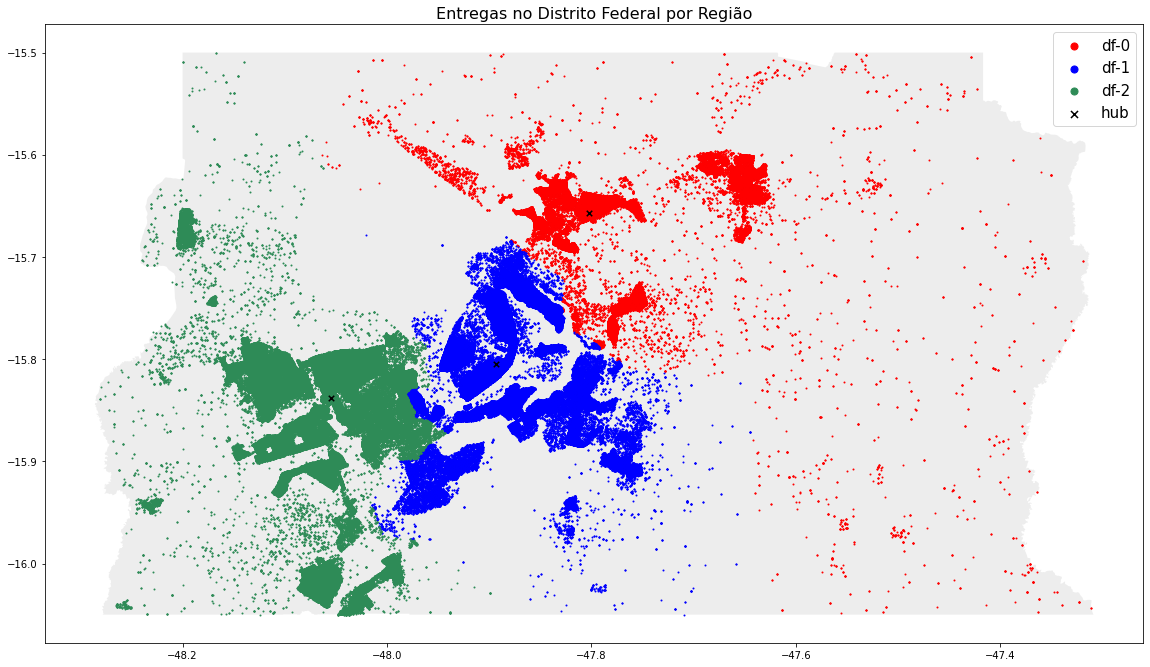

In [ ]:
# cria o plot vazio
fig, ax = plt.subplots(figsize = (50/2.54, 50/2.54))

# plot mapa do distrito federal
mapa.plot(ax=ax, alpha=0.4, color="lightgrey")

# plot das entregas
geo_deliveries_df.query("region == 'df-0'").plot(ax=ax, markersize=1, color="red", label="df-0")
geo_deliveries_df.query("region == 'df-1'").plot(ax=ax, markersize=1, color="blue", label="df-1")
geo_deliveries_df.query("region == 'df-2'").plot(ax=ax, markersize=1, color="seagreen", label="df-2")

# plot dos hubs
geo_hub_df.plot(ax=ax, markersize=30, marker="x", color="black", label="hub")

# plot da legenda
plt.title("Entregas no Distrito Federal por Região", fontdict={"fontsize": 16})
lgnd = plt.legend(prop={"size": 15})
for handle in lgnd.legendHandles:
    handle.set_sizes([50])
plt.show()

**Insights**

As entregas parecem estar corretamente alocadas em seus respectivos Hubs. No entanto, como os Hubs das regiões 0 e 2 fazem entregas em locais mais distantes do centro, isso pode gerar um tempo e preço de entrega maiores. Uma possível solução para esse problema seria redistribuir os veículos de entrega, já que as entregas dos Hubs 0 e 2 ficam mais distantes do centro de distribuição.



*   **Gráfico de entregas por região**



In [ ]:
data = pd.DataFrame(deliveries_df[['region', 'vehicle_capacity']].value_counts(normalize=True)).reset_index()
data.rename(columns={0: "region_percent"}, inplace=True)
data.head()



,region,vehicle_capacity,region_percent
0,df-1,180,0.478988
1,df-2,180,0.410783
2,df-0,180,0.110229


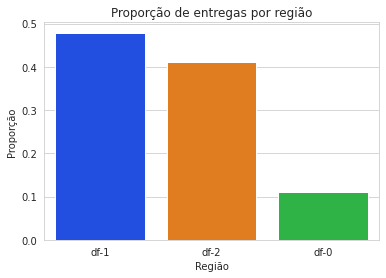

In [ ]:
with sns.axes_style('whitegrid'):
  grafico = sns.barplot(data=data, x="region", y="region_percent", ci=None, palette="bright")
  grafico.set(title='Proporção de entregas por região', xlabel='Região', ylabel='Proporção');

**Insights**

A distribuição das entregas está concentrada sobretudo nos Hubs 1 e 2, o que justifica a alocação de mais veículos para esses centros. No entanto, como vimos no mapa, o Hub 2 possui locais de entregas mais distantes, de modo que talvez seja necessário reavaliar a alocação de veículos entre os Hubs.







*   **Quantidade de entregas por cidade de destino**



In [ ]:
data = pd.DataFrame(deliveries_df[['delivery_city']].value_counts()).reset_index()
data.rename(columns={0: "delivery_amount_per_city"}, inplace=True)
data.head()

,delivery_city,delivery_amount_per_city
0,Brasília,148983
1,Taguatinga,45564
2,Sudoeste / Octogonal,44215
3,Ceilândia,37953
4,Águas Claras,37083


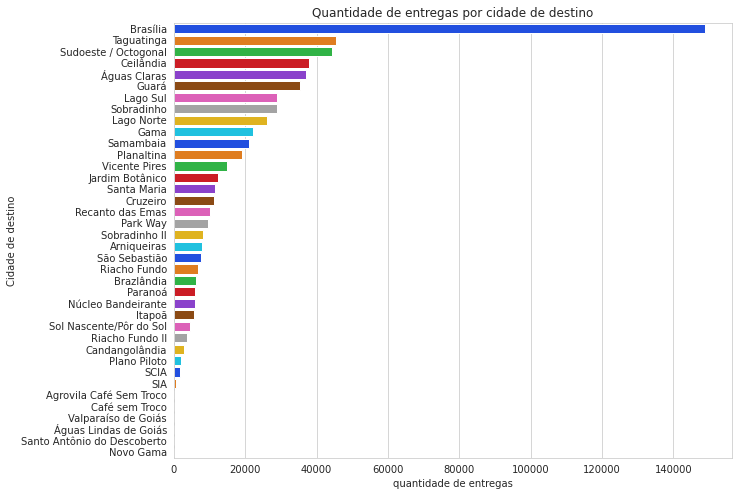

In [ ]:
with sns.axes_style('whitegrid'):
  plt.subplots(figsize=(10, 8))
  grafico = sns.barplot(data=data, x="delivery_amount_per_city", y="delivery_city", ci=None, palette="bright")
  grafico.set(title='Quantidade de entregas por cidade de destino', xlabel='quantidade de entregas', ylabel='Cidade de destino');

**Insights**

Mais uma vez vemos que há uma concentração de entregas em Brasília, onde está localizado o Hub df-1. Isso justifica, de certa forma, uma concentração maior dos veículos de entrega nesse Hub. Entretanto, há também uma dispersão de entregas em outras regiões. De novo, se olharmos o mapa, vemos que o Hub de Sobradinho possui entregas distantes do centro de distribuição, ao mesmo tempo que possui menos veículos de entrega quando comparado com outros Hubs. 



*   **Média da distância entre os Hubs e os locais de entrega por Km**



In [ ]:
data_mean_distance = deliveries_df[['region', 'disctance_hub_delivery']].groupby('region', as_index=False).agg('mean').sort_values(by=['disctance_hub_delivery'], ascending=False)
data_mean_distance = data_mean_distance.round(2)
data_mean_distance.head()

,region,disctance_hub_delivery
0,df-0,9.02
2,df-2,7.90
1,df-1,5.96


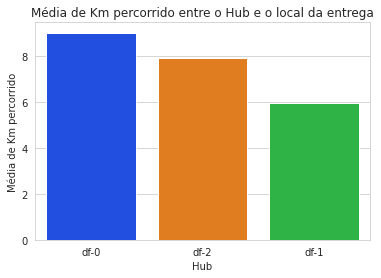

In [ ]:
with sns.axes_style('whitegrid'):
  grafico = sns.barplot(data=data_mean_distance, x="region", y="disctance_hub_delivery", ci=None, palette="bright")
  grafico.set(title='Média de Km percorrido entre o Hub e o local da entrega', xlabel='Hub', ylabel='Média de Km percorrido');



*   **Média de gasto com gasolina por entrega e por Hub**




In [ ]:
data_spent_gas = deliveries_df[['region', 'spent_on_gas']].groupby('region', as_index=False).agg('mean').sort_values(by=['spent_on_gas'], ascending=False)
data_spent_gas = data_spent_gas.round(2)
data_spent_gas.head()

,region,spent_on_gas
0,df-0,5.74
2,df-2,5.03
1,df-1,3.79


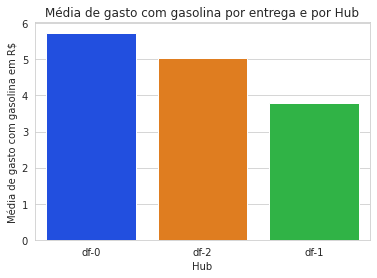

In [ ]:
with sns.axes_style('whitegrid'):
  grafico = sns.barplot(data=data_spent_gas, x="region", y="spent_on_gas", ci=None, palette="bright")
  grafico.set(title='Média de gasto com gasolina por entrega e por Hub', xlabel='Hub', ylabel='Média de gasto com gasolina em R$');

**Insights**

Apesar do Hub df-1 possuir mais entregas e, consequentemente, uma frota maior de veículos, o gasto com gasolina no Hub df-0 é maior e a média de km percorrido por entrega também é maior. Talvez seja necessário um remanejamento da frota, dando uma atenção maior às entregas do Hub df-0 e Hub df-2.